In [56]:
import pymongo as pm #import MongoClient only
import ast
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import array
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
client = pm.MongoClient('bigdatadb.polito.it',
ssl=True,
authSource = 'carsharing',
username = 'ictts',
password ='Ict4SM22!',
tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_col = db['ictts_PermanentBookings'] # Collection for Car2go to use
Enjoy_Bookings_col = db['ictts_enjoy_PermanentBookings'] # Collection for Car2go to use

with open('data/IMQ/Zone/TorinoZonesArray.geojson') as file:
    lines = file.readlines()
    
zones = [ast.literal_eval(line)[0] for line in lines]

In [57]:
zones

[[[[[7.691863740888242, 45.070489011785504],
    [7.691502277482972, 45.069976267574496],
    [7.6931049096062, 45.06940050107999],
    [7.693700390732412, 45.06917326756794],
    [7.694659975840831, 45.068837671021356],
    [7.694171859859442, 45.068237969925804],
    [7.693838193427549, 45.06782907174575],
    [7.694954578554977, 45.06740524790493],
    [7.696057454235982, 45.06698125884916],
    [7.695274080838461, 45.06637819028057],
    [7.695994498714531, 45.065909322902876],
    [7.696972771397907, 45.06527235899328],
    [7.697718763756376, 45.06479477065485],
    [7.698691242087296, 45.065548507951455],
    [7.698832714004479, 45.065401589987836],
    [7.69906763599841, 45.06542227031892],
    [7.69906279469674, 45.065390708773954],
    [7.699042169545366, 45.06537247014065],
    [7.699030276281492, 45.06535433098812],
    [7.699003903269591, 45.06532702503567],
    [7.698980500877238, 45.06530875474862],
    [7.698934977255672, 45.06528573149588],
    [7.698894509930546, 45.0

In [2]:
Bookings_col.find_one()

{'_id': ObjectId('5a3bb3af20c3dd47cf59003d'),
 'init_fuel': 53,
 'vendor': 'car2go',
 'exterior': 'GOOD',
 'vin': 'WME4533421K152664',
 'final_address': 'Corso Regina Margherita, 107, 10122 Torino TO',
 'engineType': 'CE',
 'final_date': datetime.datetime(2017, 11, 1, 0, 19, 45),
 'public_transport': {'duration': -1,
  'arrival_time': -1,
  'distance': -1,
  'arrival_date': -1},
 'final_loc': {'coordinates': [7.68634, 45.07567], 'type': 'Point'},
 'smartPhoneRequired': True,
 'init_time': 1509490770,
 'interior': 'GOOD',
 'init_address': 'Lungo Dora Napoli, 18A, 10152 Torino TO',
 'init_loc': {'coordinates': [7.68486, 45.08276], 'type': 'Point'},
 'driving': {'duration': 234, 'distance': 966},
 'final_time': 1509491985,
 'plate': '288/FF214SJ',
 'city': 'Torino',
 'final_fuel': 53,
 'init_date': datetime.datetime(2017, 10, 31, 23, 59, 30),
 'walking': {'duration': 746, 'distance': 982}}

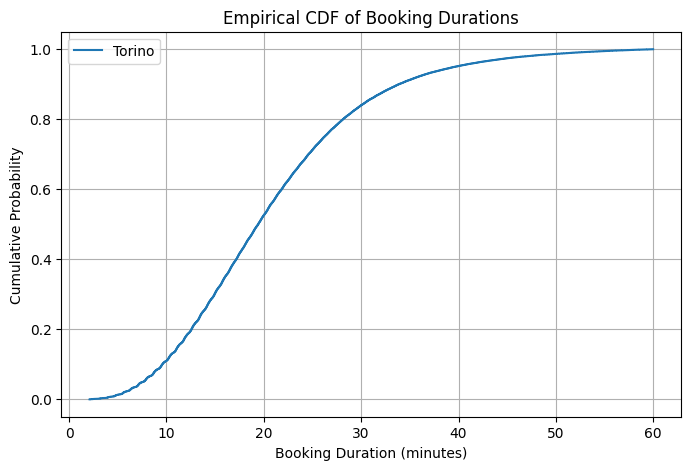

In [8]:
booking_duration = []
for doc in Bookings_col.find({"city": "Torino"}):
    booking_duration.append(doc["final_time"]- doc["init_time"])
    
booking_durations_np = np.array(booking_duration)/60
sorted_durations = np.sort(booking_durations_np)

cumulative_probabilities = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

plt.figure(figsize=(8, 5))
plt.plot(sorted_durations, cumulative_probabilities, label="Torino")


plt.xlabel("Booking Duration (minutes)")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDF of Booking Durations")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
od_matrix = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$match": { 
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix[i, j] = 0



In [66]:
od_matrix

array([[3868, 1509, 3204,  958, 1889, 1621, 1404, 1338,  691,  752,  564,
         515,  558,  496,  155,  309,  357,  233,  115,  640, 1062,  106,
         265],
       [1446,  449,  970,  288,  511,  285,  335,  451,  370,  383,  163,
         134,  154,  103,   51,   34,   43,   39,   17,  137,  371,   36,
         123],
       [3042,  979, 1195,  599, 1137,  607,  426,  336,  521,  545,  405,
         340,  347,  238,   51,   47,   73,   59,   27,   92,  294,   36,
         173],
       [ 979,  305,  706,  327,  795,  411,  199,  112,  181,  147,  255,
         192,  317,  204,   34,   45,   67,   23,   29,   36,   51,    3,
         103],
       [2021,  514, 1101,  818, 1031,  956,  621,  386,  203,  266,  345,
         255,  564,  401,  123,  171,  140,  100,   43,   94,  171,   38,
         148],
       [1666,  265,  648,  439,  945, 1011,  747,  483,  132,  140,  143,
         139,  377,  485,  201,  252,  289,  190,   73,   97,   94,   53,
          52],
       [1392,  318,  3

In [30]:
zones[0]

[[[[7.691863740888242, 45.070489011785504],
   [7.691502277482972, 45.069976267574496],
   [7.6931049096062, 45.06940050107999],
   [7.693700390732412, 45.06917326756794],
   [7.694659975840831, 45.068837671021356],
   [7.694171859859442, 45.068237969925804],
   [7.693838193427549, 45.06782907174575],
   [7.694954578554977, 45.06740524790493],
   [7.696057454235982, 45.06698125884916],
   [7.695274080838461, 45.06637819028057],
   [7.695994498714531, 45.065909322902876],
   [7.696972771397907, 45.06527235899328],
   [7.697718763756376, 45.06479477065485],
   [7.698691242087296, 45.065548507951455],
   [7.698832714004479, 45.065401589987836],
   [7.69906763599841, 45.06542227031892],
   [7.69906279469674, 45.065390708773954],
   [7.699042169545366, 45.06537247014065],
   [7.699030276281492, 45.06535433098812],
   [7.699003903269591, 45.06532702503567],
   [7.698980500877238, 45.06530875474862],
   [7.698934977255672, 45.06528573149588],
   [7.698894509930546, 45.0652672667512],
   [7.69

In [126]:
zone_counts = []

for zone in zones:
    coordinates = np.array(zone)
    pipeline = [
        {"$match": 
            {"init_loc": 
                {"$geoWithin": 
                    {"$geometry": 
                        {"type": "MultiPolygon", 
                            "coordinates": coordinates
                        }
                    }
                },
                "final_loc": 
                {"$geoWithin": 
                    {"$geometry": 
                        {"type": "MultiPolygon", 
                            "coordinates": coordinates
                        }
                    }
                }
            }
        },
        {"$count": "tot"}
    ]
    result = list(Bookings_col.aggregate(pipeline))
    zone_counts.append(result[0]['tot'] if result else 0)

zone_counts

InvalidDocument: cannot encode object: array([[[[ 7.69186374, 45.07048901],
         [ 7.69150228, 45.06997627],
         [ 7.69310491, 45.0694005 ],
         [ 7.69370039, 45.06917327],
         [ 7.69465998, 45.06883767],
         [ 7.69417186, 45.06823797],
         [ 7.69383819, 45.06782907],
         [ 7.69495458, 45.06740525],
         [ 7.69605745, 45.06698126],
         [ 7.69527408, 45.06637819],
         [ 7.6959945 , 45.06590932],
         [ 7.69697277, 45.06527236],
         [ 7.69771876, 45.06479477],
         [ 7.69869124, 45.06554851],
         [ 7.69883271, 45.06540159],
         [ 7.69906764, 45.06542227],
         [ 7.69906279, 45.06539071],
         [ 7.69904217, 45.06537247],
         [ 7.69903028, 45.06535433],
         [ 7.6990039 , 45.06532703],
         [ 7.6989805 , 45.06530875],
         [ 7.69893498, 45.06528573],
         [ 7.69889451, 45.06526727],
         [ 7.69885205, 45.06526678],
         [ 7.69882566, 45.06525748],
         [ 7.69879342, 45.06526161],
         [ 7.6987724 , 45.06524337],
         [ 7.69873458, 45.06526544],
         [ 7.6985881 , 45.06517826],
         [ 7.69858207, 45.06514668],
         [ 7.69857692, 45.06512862],
         [ 7.69854509, 45.06511475],
         [ 7.69851713, 45.06508743],
         [ 7.6984832 , 45.06507804],
         [ 7.6984589 , 45.06506426],
         [ 7.69842022, 45.06505482],
         [ 7.6983836 , 45.0650589 ],
         [ 7.69828137, 45.06498122],
         [ 7.69825201, 45.06496288],
         [ 7.69814094, 45.0648896 ],
         [ 7.69812191, 45.06487138],
         [ 7.69802849, 45.0648073 ],
         [ 7.69800975, 45.06479359],
         [ 7.69770196, 45.06455603],
         [ 7.69712602, 45.06413538],
         [ 7.69710768, 45.06412166],
         [ 7.69688081, 45.06393904],
         [ 7.69687854, 45.06391651],
         [ 7.69711408, 45.06375266],
         [ 7.69714829, 45.06376656],
         [ 7.69717617, 45.06376237],
         [ 7.69718542, 45.06373997],
         [ 7.69718593, 45.06371748],
         [ 7.69739734, 45.06356686],
         [ 7.69742918, 45.06358072],
         [ 7.69745965, 45.06356757],
         [ 7.69746998, 45.06354968],
         [ 7.6975083 , 45.06350511],
         [ 7.69744771, 45.06346391],
         [ 7.69739585, 45.06342281],
         [ 7.69735476, 45.06344935],
         [ 7.69729801, 45.0634487 ],
         [ 7.69729511, 45.06348917],
         [ 7.69706098, 45.06362603],
         [ 7.6970217 , 45.06362558],
         [ 7.69700155, 45.06363886],
         [ 7.6970057 , 45.06366591],
         [ 7.69678108, 45.06382088],
         [ 7.69673208, 45.06381132],
         [ 7.69656747, 45.06370142],
         [ 7.69649856, 45.06364212],
         [ 7.6964823 , 45.06362393],
         [ 7.69561786, 45.06295692],
         [ 7.69552208, 45.06287481],
         [ 7.69550344, 45.0628566 ],
         [ 7.69536058, 45.06271544],
         [ 7.69532113, 45.06266998],
         [ 7.69531648, 45.06264742],
         [ 7.69527039, 45.06259738],
         [ 7.69523654, 45.0626195 ],
         [ 7.69514166, 45.0625329 ],
         [ 7.6951504 , 45.06251499],
         [ 7.69513783, 45.06247434],
         [ 7.69512704, 45.06244271],
         [ 7.69511287, 45.06242005],
         [ 7.69509701, 45.06240186],
         [ 7.6950527 , 45.06236085],
         [ 7.6950311 , 45.06231559],
         [ 7.69486483, 45.06217416],
         [ 7.69481972, 45.06213314],
         [ 7.69466714, 45.06200087],
         [ 7.69460565, 45.06196416],
         [ 7.69447331, 45.06183212],
         [ 7.69443148, 45.06178663],
         [ 7.69428783, 45.06164546],
         [ 7.69424272, 45.06160443],
         [ 7.69409659, 45.06146774],
         [ 7.69405307, 45.06142673],
         [ 7.69393777, 45.06131289],
         [ 7.69384925, 45.06122636],
         [ 7.6937406 , 45.06111709],
         [ 7.69369718, 45.06107159],
         [ 7.69357148, 45.06094412],
         [ 7.69352965, 45.06089864],
         [ 7.69340713, 45.06077121],
         [ 7.69336688, 45.06072574],
         [ 7.69334517, 45.06070299],
         [ 7.6932631 , 45.06061203],
         [ 7.69324567, 45.06057582],
         [ 7.69323478, 45.06054869],
         [ 7.69322031, 45.06052152],
         [ 7.6931996 , 45.06048978],
         [ 7.69317453, 45.06045798],
         [ 7.69314597, 45.06043965],
         [ 7.69312555, 45.06041241],
         [ 7.69309095, 45.06038051],
         [ 7.69300697, 45.06032104],
         [ 7.69293035, 45.06023464],
         [ 7.69290557, 45.06020735],
         [ 7.69286642, 45.0601664 ],
         [ 7.69274451, 45.06001197],
         [ 7.69270903, 45.05996656],
         [ 7.69259308, 45.0598122 ],
         [ 7.6925577 , 45.05976228],
         [ 7.69253649, 45.05973503],
         [ 7.69251677, 45.0597123 ],
         [ 7.69248504, 45.05969394],
         [ 7.69245509, 45.05968459],
         [ 7.69241521, 45.05967513],
         [ 7.69224513, 45.05947515],
         [ 7.69218825, 45.05939348],
         [ 7.69158971, 45.05855845],
         [ 7.69147457, 45.05852563],
         [ 7.69143879, 45.05847571],
         [ 7.69145062, 45.05844434],
         [ 7.69145571, 45.05841289],
         [ 7.69144383, 45.05837674],
         [ 7.69144139, 45.05832721],
         [ 7.69160075, 45.05826602],
         [ 7.691775  , 45.058196  ],
         [ 7.69179918, 45.05823228],
         [ 7.69182923, 45.05823713],
         [ 7.69184988, 45.05821936],
         [ 7.69184435, 45.05818329],
         [ 7.69201115, 45.05812669],
         [ 7.69194288, 45.05802239],
         [ 7.6913485 , 45.05824062],
         [ 7.69074875, 45.0584858 ],
         [ 7.68926271, 45.05900886],
         [ 7.68825145, 45.05937083],
         [ 7.68782417, 45.05951895],
         [ 7.68783888, 45.05936158],
         [ 7.68736326, 45.05870799],
         [ 7.68688735, 45.05806788],
         [ 7.68628255, 45.05723276],
         [ 7.68463693, 45.05782594],
         [ 7.68330951, 45.05830124],
         [ 7.68223055, 45.05868938],
         [ 7.68104898, 45.05910332],
         [ 7.68041507, 45.05933004],
         [ 7.67995937, 45.05950481],
         [ 7.67986767, 45.05953976],
         [ 7.67935602, 45.05971388],
         [ 7.67929855, 45.05974472],
         [ 7.67846565, 45.06004565],
         [ 7.67832128, 45.06007549],
         [ 7.67815515, 45.06013658],
         [ 7.67634286, 45.06077272],
         [ 7.67619558, 45.06082502],
         [ 7.67607778, 45.06087316],
         [ 7.67539932, 45.05993361],
         [ 7.67486779, 45.06012548],
         [ 7.67411693, 45.06039582],
         [ 7.67345409, 45.06063567],
         [ 7.67277527, 45.06087984],
         [ 7.67168975, 45.06127229],
         [ 7.6706197 , 45.06164692],
         [ 7.67017625, 45.06182179],
         [ 7.6689448 , 45.06225754],
         [ 7.66864988, 45.06232611],
         [ 7.66864988, 45.06232611],
         [ 7.66827767, 45.06240729],
         [ 7.6670017 , 45.0628785 ],
         [ 7.66556208, 45.06338829],
         [ 7.66481233, 45.06365859],
         [ 7.66412857, 45.06390714],
         [ 7.66410535, 45.0639166 ],
         [ 7.66389214, 45.06400339],
         [ 7.66365758, 45.06407898],
         [ 7.66362258, 45.06409026],
         [ 7.66350468, 45.06413443],
         [ 7.66274882, 45.0644176 ],
         [ 7.66182961, 45.0647534 ],
         [ 7.66249838, 45.06569292],
         [ 7.66313457, 45.06660056],
         [ 7.66358479, 45.06724496],
         [ 7.66450392, 45.06691364],
         [ 7.66496061, 45.06755361],
         [ 7.66505549, 45.06768975],
         [ 7.66407719, 45.06803838],
         [ 7.66417098, 45.06825552],
         [ 7.66472412, 45.06904965],
         [ 7.66516209, 45.06967589],
         [ 7.66557075, 45.07026579],
         [ 7.6659395 , 45.0707967 ],
         [ 7.66632519, 45.07135032],
         [ 7.66695269, 45.07108309],
         [ 7.66743017, 45.07089963],
         [ 7.66743017, 45.07089963],
         [ 7.66807633, 45.07179384],
         [ 7.66868089, 45.07256605],
         [ 7.66913835, 45.07321051],
         [ 7.66921477, 45.07328792],
         [ 7.6697599 , 45.07407292],
         [ 7.67019627, 45.07470363],
         [ 7.67149796, 45.07424619],
         [ 7.67252437, 45.07388005],
         [ 7.67288579, 45.07438835],
         [ 7.673035  , 45.07459713],
         [ 7.67327189, 45.07492845],
         [ 7.67351958, 45.07527339],
         [ 7.67413487, 45.07613571],
         [ 7.67455636, 45.07672572],
         [ 7.67497321, 45.07731118],
         [ 7.67563047, 45.07708025],
         [ 7.67567544, 45.07705827],
         [ 7.6763863 , 45.07680996],
         [ 7.67648129, 45.07678856],
         [ 7.67735215, 45.07648809],
         [ 7.67821497, 45.07619202],
         [ 7.67887358, 45.07597009],
         [ 7.67904301, 45.07592254],
         [ 7.67949624, 45.07577475],
         [ 7.67953202, 45.07582468],
         [ 7.68048824, 45.07547116],
         [ 7.68082323, 45.07537151],
         [ 7.68140214, 45.07516215],
         [ 7.68235732, 45.07483561],
         [ 7.68248497, 45.07479207],
         [ 7.68305067, 45.07456905],
         [ 7.68349815, 45.07439418],
         [ 7.68363317, 45.07432372],
         [ 7.68410237, 45.07415359],
         [ 7.68422237, 45.07411447],
         [ 7.68466903, 45.07395758],
         [ 7.68496849, 45.07384851],
         [ 7.68464215, 45.07327763],
         [ 7.68458865, 45.073187  ],
         [ 7.68417772, 45.07256564],
         [ 7.68391013, 45.07222049],
         [ 7.68497351, 45.07188167],
         [ 7.68539572, 45.0717515 ],
         [ 7.6861432 , 45.07147655],
         [ 7.68623547, 45.07160813],
         [ 7.68633743, 45.07176684],
         [ 7.68723498, 45.07143959],
         [ 7.68725262, 45.0714668 ],
         [ 7.68729559, 45.07146279],
         [ 7.68731158, 45.07144047],
         [ 7.68735337, 45.07141845],
         [ 7.68752835, 45.07135295],
         [ 7.68764051, 45.07130923],
         [ 7.68772309, 45.07127417],
         [ 7.68780449, 45.0712391 ],
         [ 7.68949731, 45.07062841],
         [ 7.68984151, 45.07050634],
         [ 7.68986847, 45.07054265],
         [ 7.68992465, 45.07051629],
         [ 7.68998718, 45.07049   ],
         [ 7.68997618, 45.07046737],
         [ 7.69010849, 45.07041038],
         [ 7.69056423, 45.07025357],
         [ 7.69072988, 45.07019696],
         [ 7.6908386 , 45.07035574],
         [ 7.69114793, 45.07052582],
         [ 7.69165809, 45.07095925],
         [ 7.69208982, 45.07081117],
         [ 7.69186374, 45.07048901]]]]), of type: <class 'numpy.ndarray'>

In [ ]:
zones.forEach(zone => {
    Bookings_col.aggregate([
    {
        $match: {
        location: {
            $geoWithin: {
            $geometry: zone.polygon
            }
        }
      }
    },
    {
      $group: {
        _id: zone.name,
        count: { $sum: 1 }
      }
    }
  ]).forEach(result => {
    printjson(result);
  });
});

In [55]:
len(zones)
zones[0][0][0]

[[7.691863740888242, 45.070489011785504],
 [7.691502277482972, 45.069976267574496],
 [7.6931049096062, 45.06940050107999],
 [7.693700390732412, 45.06917326756794],
 [7.694659975840831, 45.068837671021356],
 [7.694171859859442, 45.068237969925804],
 [7.693838193427549, 45.06782907174575],
 [7.694954578554977, 45.06740524790493],
 [7.696057454235982, 45.06698125884916],
 [7.695274080838461, 45.06637819028057],
 [7.695994498714531, 45.065909322902876],
 [7.696972771397907, 45.06527235899328],
 [7.697718763756376, 45.06479477065485],
 [7.698691242087296, 45.065548507951455],
 [7.698832714004479, 45.065401589987836],
 [7.69906763599841, 45.06542227031892],
 [7.69906279469674, 45.065390708773954],
 [7.699042169545366, 45.06537247014065],
 [7.699030276281492, 45.06535433098812],
 [7.699003903269591, 45.06532702503567],
 [7.698980500877238, 45.06530875474862],
 [7.698934977255672, 45.06528573149588],
 [7.698894509930546, 45.0652672667512],
 [7.698852048147163, 45.06526678291675],
 [7.698825663